# Analyse du jeu de données DVF - Appartements à Paris

L"objectif est d"analyser les transactions pour les **appartements** situés à **Paris** entre 2017 et 2022:
- Filtres statiques
- Modèles de régression
- Valeurs aberrantes
- Contribution des variables

## Setup

In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lib.preprocessing import dvf

In [4]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm 
from multiprocessing import cpu_count

import seaborn as sns 
import matplotlib.pyplot as plt 

import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from sklearn.linear_model import (
    LinearRegression, 
    Ridge, 
    Lasso, 
    ElasticNet
) 

from sklearn.dummy import DummyRegressor

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    make_scorer
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import sqlalchemy
from optuna import Trial, create_study

In [5]:
CPU_COUNT = cpu_count()
CPU_COUNT

8

In [6]:
pd.set_option("display.max_columns", None)

In [7]:
DATA_DIR = "../data/"
ZIP_DIR = f"{DATA_DIR}cleaned.zip" 

## Data

On fusionne les jeux de données de 2017 à 2022 pour les **appartements** de la ville de **Paris**.

In [8]:
df = dvf.concat_datasets_per_year(ZIP_DIR, geo_area="Paris", property_type="flats")

Processing 2022: 100%|██████████| 6/6 [03:07<00:00, 31.29s/it]


In [9]:
df.tail()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,dependance,code_region,nom_departement,nom_region,degre_densite,pop,annee,trimestre,mois,jour
160752,2022-537265,2022-05-17,1,Vente,130000.0,20.0,NaN,RUE PIERRE LEROUX,7451,75007.0,75107,Paris 7e Arrondissement,75,NaN,NaN,75107000BG0031,NaN,NaN,12.0,10.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,11.0,1.0,NaN,NaN,NaN,NaN,NaN,2.319004,48.849079,0,11,Paris,Île-de-France,Paris,52512.0,2022,2,5,17
160753,2022-537266,2022-06-22,1,Vente,330375.0,10.0,NaN,RUE DU CHEVALERET,1990,75013.0,75113,Paris 13e Arrondissement,75,NaN,NaN,75113000CI0017,NaN,NaN,22.0,NaN,37.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3,2.0,Appartement,40.0,2.0,NaN,NaN,NaN,NaN,NaN,2.378447,48.825798,0,11,Paris,Île-de-France,Paris,181552.0,2022,2,6,22
160754,2022-537267,2022-06-29,1,Vente,2801244.0,3.0,NaN,VLA JOCELYN,4983,75016.0,75116,Paris 16e Arrondissement,75,NaN,NaN,75116000EB0007,NaN,NaN,313.0,183.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,172.0,6.0,NaN,NaN,NaN,NaN,NaN,2.276055,48.865299,1,11,Paris,Île-de-France,Paris,165446.0,2022,2,6,29
160755,2022-537271,2022-06-21,1,Vente,423000.0,43.0,NaN,RUE DES FAVORITES,3536,75015.0,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000AC0055,NaN,NaN,16.0,NaN,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,43.0,2.0,NaN,NaN,NaN,NaN,NaN,2.305379,48.837454,1,11,Paris,Île-de-France,Paris,233484.0,2022,2,6,21
160756,2022-537272,2022-06-30,1,Vente,104650.0,50.0,NaN,RUE LEON FROT,5554,75011.0,75111,Paris 11e Arrondissement,75,NaN,NaN,75111000BS0234,NaN,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,15.0,1.0,NaN,NaN,NaN,NaN,NaN,2.386354,48.856079,0,11,Paris,Île-de-France,Paris,147017.0,2022,2,6,30


In [10]:
df.shape

(160757, 50)

In [11]:
n_unique_ids = df.id_mutation.unique().shape[0]
assert n_unique_ids == df.shape[0]

print(f"{n_unique_ids} transactions uniques pour les appartements à Paris")

160757 transactions uniques pour les appartements à Paris


### Sélection des variables

In [12]:
VARS = [
    "id_mutation", 
    "valeur_fonciere",
    "nom_commune",
    "longitude",
    "latitude", 
    "pop", 
    "annee", 
    "trimestre", 
    "mois", 
    "jour", 
    "dependance", 
    "surface_terrain", 
    "surface_reelle_bati", 
    "nombre_pieces_principales" 
]

df2 = df.loc[:, df.columns.isin(VARS)]

In [13]:
df2.shape

(160757, 14)

### Filtres statiques

**Objectif** : éliminer les biens ayant des caractéristiques aberrantes pouvant ajouter du bruit aux données

In [14]:
df2.describe()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,dependance,pop,annee,trimestre,mois,jour
count,1.606820e+05,160756.000000,160756.000000,138.000000,160593.000000,160593.000000,160757.000000,160757.000000,160757.000000,160757.000000,160757.00000,160757.000000
mean,5.774656e+05,53.627877,2.411282,420.840580,2.340310,48.862293,0.278737,146606.664686,2019.485030,2.534154,6.62439,16.565157
std,8.807797e+05,39.868650,1.296799,576.248847,0.037832,0.019980,0.448379,61840.601802,1.526087,1.109350,3.39794,8.881552
min,1.500000e-01,1.000000,0.000000,33.000000,2.255896,48.818759,0.000000,16252.000000,2017.000000,1.000000,1.00000,1.000000
25%,2.550000e+05,28.000000,1.000000,144.250000,2.310880,48.845756,0.000000,91932.000000,2018.000000,2.000000,4.00000,9.000000
50%,4.100000e+05,43.000000,2.000000,210.500000,2.343348,48.862767,0.000000,165446.000000,2019.000000,3.000000,7.00000,17.000000
75%,6.775000e+05,68.000000,3.000000,453.250000,2.371079,48.879998,1.000000,195060.000000,2021.000000,4.000000,10.00000,25.000000
max,1.315000e+08,1500.000000,26.000000,4006.000000,2.412825,48.900565,1.000000,233484.000000,2022.000000,4.000000,12.00000,31.000000


#### Nombre de pièces principales

Suppression des biens de + de 8 pièces principales et des biens ayant aucune pièce principale. 

In [15]:
df2.nombre_pieces_principales.value_counts()

2.0     54848
1.0     42061
3.0     36110
4.0     16434
5.0      7127
6.0      2551
7.0       969
8.0       299
0.0       196
9.0        75
10.0       47
11.0       17
12.0        6
13.0        3
17.0        2
16.0        2
20.0        2
22.0        1
21.0        1
19.0        1
23.0        1
26.0        1
14.0        1
15.0        1
Name: nombre_pieces_principales, dtype: int64

In [16]:
df2 = df2.loc[
    (df2.nombre_pieces_principales > 0) &
    (df2.nombre_pieces_principales <= 8),
    :
]

# convert to integer
df2["nombre_pieces_principales"] = df2["nombre_pieces_principales"].astype(int)

In [17]:
df2.nombre_pieces_principales.value_counts()

2    54848
1    42061
3    36110
4    16434
5     7127
6     2551
7      969
8      299
Name: nombre_pieces_principales, dtype: int64

#### Surface du bien

Au regard des graphiques suivants, il semble pertinent de garder les biens ayant une surface inférieure ou égale à 150m².

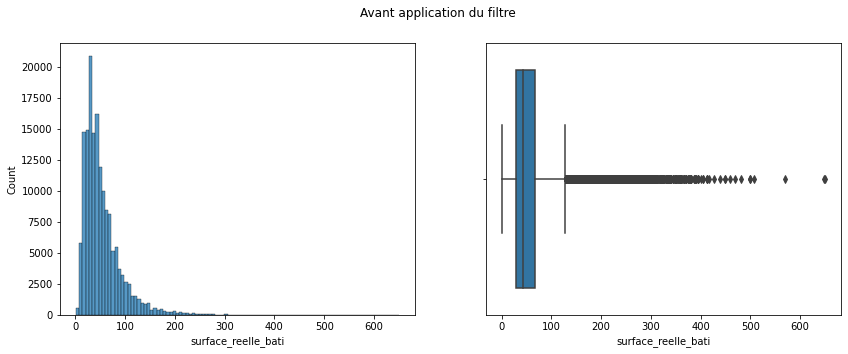

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Avant application du filtre")

sns.histplot(data=df2, x="surface_reelle_bati", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="surface_reelle_bati", ax=axes[1]);  

In [19]:
df2 = df2.loc[df2.surface_reelle_bati <= 150, :]

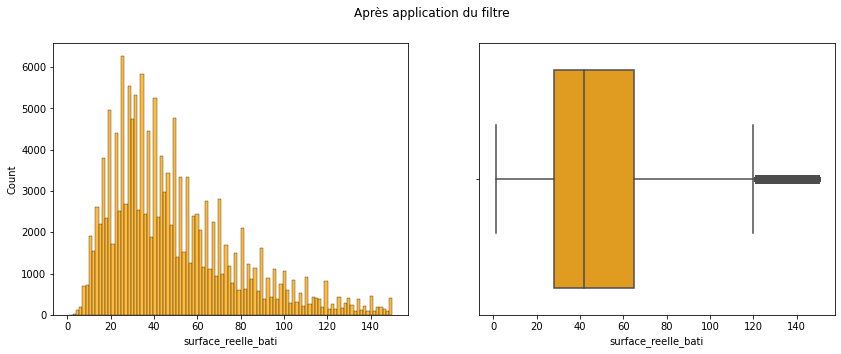

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Après application du filtre")

sns.histplot(data=df2, x="surface_reelle_bati", color="orange", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="surface_reelle_bati", color="orange", ax=axes[1]);  

#### Surface terrain

On commence par mettre à 0 les valeurs manquantes dans la colonne `surface_terrain`. 

In [21]:
def encode_field_area(area: float) -> float: 

    if pd.isna(area): 
        area = 0
    return area 

assert encode_field_area(float("nan")) == 0
assert encode_field_area(102.) == 102.
 
df2["surface_terrain"] = df2["surface_terrain"].apply(encode_field_area) 

In [22]:
df2["surface_terrain"].describe()

count    155880.000000
mean          0.361656
std          21.106382
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4006.000000
Name: surface_terrain, dtype: float64

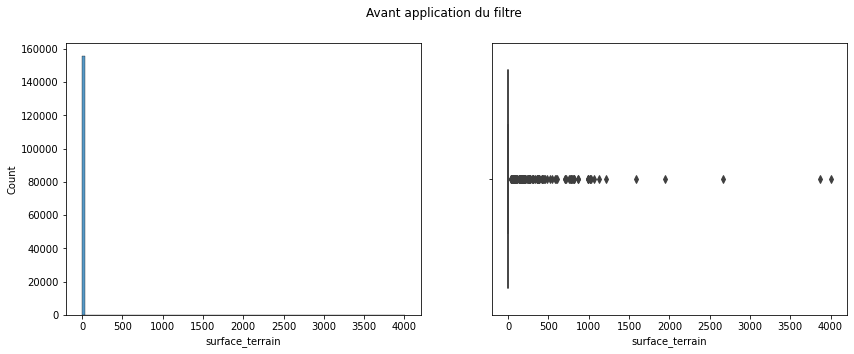

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.suptitle("Avant application du filtre")

sns.histplot(data=df2, x="surface_terrain", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="surface_terrain", ax=axes[1]);  

In [24]:
df2.loc[df2.surface_terrain == 0].shape[0] / df2.shape[0]

0.9991852707210674

La surface du terrain est nulle pour la majorité des biens (99.91%), ce qui fait sens puisque ce sont des appartements à Paris. On décide donc de supprimer cette variable du jeu de données utilisé pour la modélisation. 

In [25]:
df2 = df2\
    .loc[df2.surface_terrain == 0, :]\
    .drop(labels=["surface_terrain"], axis=1)

In [26]:
df2.shape

(155753, 13)

In [27]:
df2.columns

Index(['id_mutation', 'valeur_fonciere', 'nom_commune', 'surface_reelle_bati',
       'nombre_pieces_principales', 'longitude', 'latitude', 'dependance',
       'pop', 'annee', 'trimestre', 'mois', 'jour'],
      dtype='object')

### Variable cible : `valeur_fonciere`

In [28]:
df2["valeur_fonciere"].describe()

count    1.556800e+05
mean     5.116951e+05
std      4.219849e+05
min      1.500000e-01
25%      2.500000e+05
50%      4.000000e+05
75%      6.490000e+05
max      2.700000e+07
Name: valeur_fonciere, dtype: float64

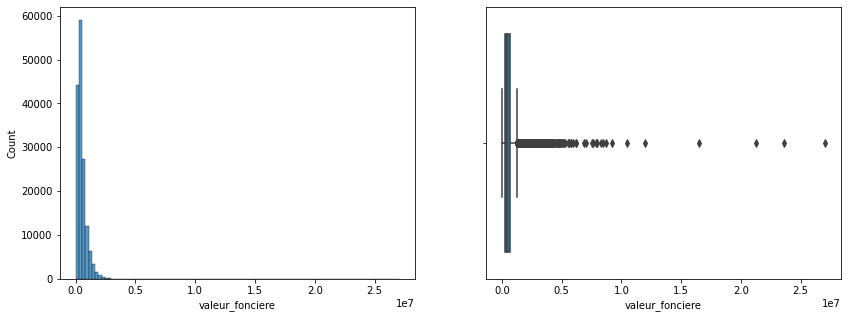

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.histplot(data=df2, x="valeur_fonciere", bins=100, ax=axes[0])
sns.boxplot(data=df2, x="valeur_fonciere", ax=axes[1]);  

On décide de transfomer la variable `valeur_fonciere` en divisant par la surface du bien (en m²) puis en prenant le logarithme. On obtient la variable `l_valeur_fonciere_m2`: 

$$
\text{l\_valeur\_fonciere\_m2} = \log \Big(\frac{\text{valeur\_fonciere}}{\text{surface\_reelle\_bati}} \Big)
$$

In [30]:
def transform_target_variable(price: float, area: float) -> float: 
    return np.log(price / area)

df2["l_valeur_fonciere_m2"] = df2.apply(lambda row: transform_target_variable(row.valeur_fonciere, row.surface_reelle_bati), axis=1) 

In [31]:
df2["l_valeur_fonciere_m2"].describe()

count    155680.000000
mean          9.083329
std           0.943836
min          -5.585999
25%           9.051647
50%           9.225845
75%           9.382191
max          13.978105
Name: l_valeur_fonciere_m2, dtype: float64

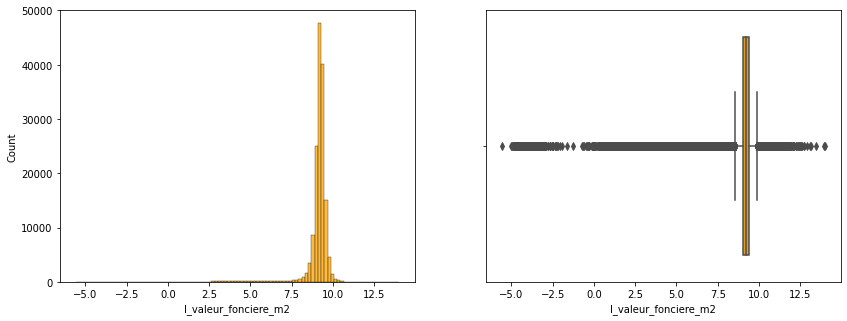

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.histplot(data=df2, x="l_valeur_fonciere_m2", bins=100, ax=axes[0], color="orange")
sns.boxplot(data=df2, x="l_valeur_fonciere_m2", ax=axes[1], color="orange");  

On décide de représenter la distribution de la variable cible sur l"intervalle $[8, 10]$ au vu du précédent graphique. Cela signifie que l"on représente des biens dont la valeur foncière par m² est comprise entre 2 980€ et 22 026€.

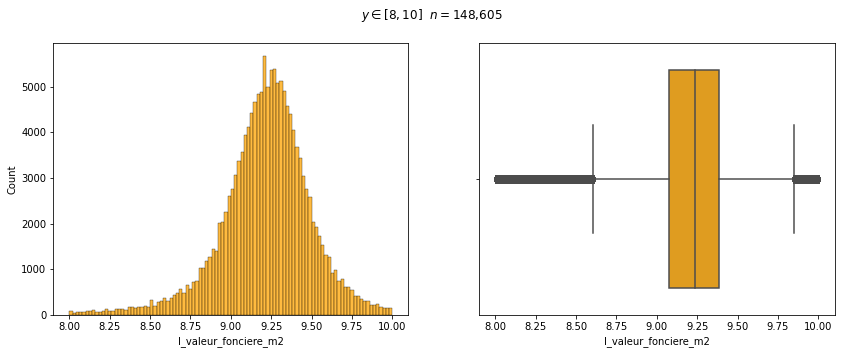

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

tmp = df2.loc[
    (df2.l_valeur_fonciere_m2 >= 8) & 
    (df2.l_valeur_fonciere_m2 <= 10), 
    :
]
n = tmp.shape[0]

fig.suptitle(rf"$y \in [8, 10] \ \ n=${n:,}")

sns.histplot(data=tmp, x="l_valeur_fonciere_m2", bins=100, ax=axes[0], color="orange")
sns.boxplot(data=tmp, x="l_valeur_fonciere_m2", ax=axes[1], color="orange")

del tmp; 

In [34]:
df2 = df2.loc[
    (df2.l_valeur_fonciere_m2 >= 8) & 
    (df2.l_valeur_fonciere_m2 <= 10), 
    :
]

### Ajout de la variable `arrondissement`

On isole les arrondissements à partir de la variable `nom_commune`. 

In [35]:
DIGIT = r"[0-9]+"
import re

def extract_int_from_string(string: str) -> int: 
    integer = re.findall(DIGIT, string)

    if len(integer) > 1: 
        raise ValueError("Multiple integers found.")
    return integer[0]

In [36]:
df2["arrondissement"] = df2.nom_commune.apply(extract_int_from_string)

In [37]:
df2.arrondissement.value_counts() / df2.shape[0]

18    0.112708
15    0.109095
17    0.086605
11    0.084371
16    0.079614
20    0.068537
19    0.057522
12    0.054803
10    0.052966
14    0.052461
13    0.049278
9     0.037368
5     0.026022
7     0.024770
6     0.022240
3     0.021527
8     0.018290
2     0.016460
4     0.015787
1     0.009576
Name: arrondissement, dtype: float64

### Encodage du type des variables

In [85]:
CAT_VARS = [
    "nombre_pieces_principales", 
    "dependance", 
    "arrondissement", 
    "annee", 
    "trimestre", 
    "mois"
]

QUANT_VARS = [
    "valeur_fonciere", 
    "l_valeur_fonciere_m2", 
    "surface_reelle_bati", 
    "longitude", 
    "latitude", 
    "pop"
]

df3 = df2.loc[:, QUANT_VARS+CAT_VARS]

df3.loc[:, CAT_VARS] = df2.loc[:, CAT_VARS].astype(object)
df3.loc[:, QUANT_VARS] = df3.loc[:, QUANT_VARS].astype(float)

In [39]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148605 entries, 0 to 160756
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   l_valeur_fonciere_m2       148605 non-null  float64
 1   surface_reelle_bati        148605 non-null  float64
 2   longitude                  148457 non-null  float64
 3   latitude                   148457 non-null  float64
 4   pop                        148605 non-null  float64
 5   nombre_pieces_principales  148605 non-null  object 
 6   dependance                 148605 non-null  object 
 7   arrondissement             148605 non-null  object 
 8   annee                      148605 non-null  object 
 9   trimestre                  148605 non-null  object 
 10  mois                       148605 non-null  object 
dtypes: float64(5), object(6)
memory usage: 13.6+ MB


### Croisement entre variables

In [86]:
cor_mat = df2[QUANT_VARS]\
    .corr(method="pearson")\
    [["l_valeur_fonciere_m2"]]\
    .sort_values(by="l_valeur_fonciere_m2", ascending=False)
    
cor_mat

,l_valeur_fonciere_m2
l_valeur_fonciere_m2,1.000000
valeur_fonciere,0.427451
surface_reelle_bati,0.079563
latitude,-0.053189
longitude,-0.193540
pop,-0.288968


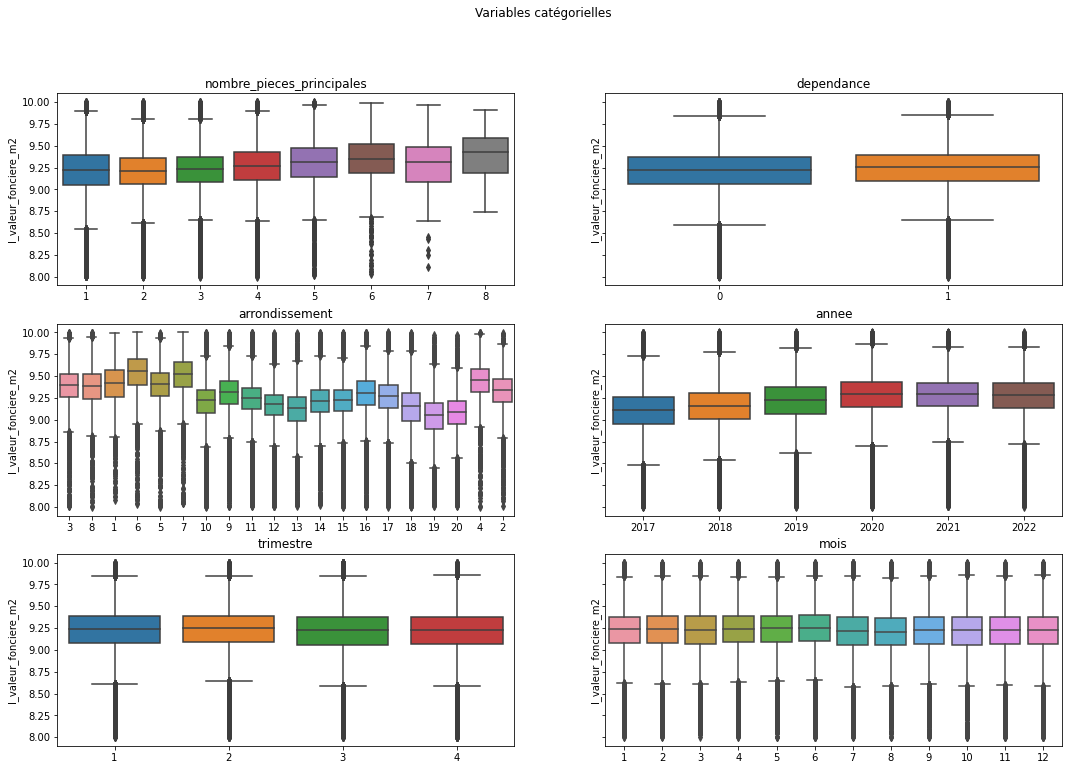

In [41]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(18, 12), sharey=True)
fig.suptitle("Variables catégorielles")

for var, ax in zip(CAT_VARS, axes.flatten()):
    sns.boxplot(data=df3, x=var, y="l_valeur_fonciere_m2", ax=ax)
    ax.set_title(var)
    ax.set_xlabel(""); 

### Sélection des variables discriminantes

Au vu des graphiques précédents, on sélectionne uniquement les variables dummies liés aux nombre de pièces, arrondissements, trimestres et années ainsi que la dummy `dependance`. La seule variable quantitative intéressante est `surface_relle_bati` mais elle est déjà utilisée pour construire la variable cible. 

In [87]:
df_mod = df3[[
    "l_valeur_fonciere_m2", 
    "nombre_pieces_principales", 
    "dependance", 
    "arrondissement", 
    "annee", 
    "trimestre"
]]

### Transformation des variables catégorielles

On transforme chaque variable catégorielle $\mathrm{x}_{cat, k}$, contenant $n_k$ niveaux, en $n_k-1$ variables indicatrices. 

Les variables considérées sont : 
- `nombre_pieces_principales`
- `dependance`
- `annee`
- `trimestre`
- `arrondissement`

On peut utiliser la fonction `pd.get_dummies()` pour transformer les variables catégorielles.

In [43]:
df_mod = pd.get_dummies(data=df_mod, drop_first=True)

In [44]:
df_mod.head()

,l_valeur_fonciere_m2,nombre_pieces_principales_2,nombre_pieces_principales_3,nombre_pieces_principales_4,nombre_pieces_principales_5,nombre_pieces_principales_6,nombre_pieces_principales_7,nombre_pieces_principales_8,dependance_1,arrondissement_10,arrondissement_11,arrondissement_12,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_18,arrondissement_19,arrondissement_2,arrondissement_20,arrondissement_3,arrondissement_4,arrondissement_5,arrondissement_6,arrondissement_7,arrondissement_8,arrondissement_9,annee_2018,annee_2019,annee_2020,annee_2021,annee_2022,trimestre_2,trimestre_3,trimestre_4
0,9.517667,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,9.366489,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,9.136232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,9.454318,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,9.198219,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


### Suppression des valeurs manquantes

On supprime les lignes ayant au moins une valeur manquante. Des méthodes d"imputation pourraient être envisagées par la suite. 

In [45]:
df_mod = df_mod.dropna()

In [46]:
n, p = df_mod.shape
print(f"{p} variables et {n} observations")

36 variables et 148605 observations


### Train/test split

On divise le jeu de données en 2: 
- 80% de données d"entrainement
- 20% de données test

In [62]:
target = "l_valeur_fonciere_m2"

X = df_mod.drop(labels=[target], axis=1)
feature_names = X.columns.tolist()

y = df3[target]

In [65]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=.8)

In [88]:
# keep areas and unscaled prices for train and test samples

train_idxs = X_tr.index.values
test_idxs = X_te.index.values

train_areas = df3.loc[df3.index.isin(train_idxs), "surface_reelle_bati"]
test_areas = df3.loc[df3.index.isin(test_idxs), "surface_reelle_bati"]

train_prices = df3.loc[df3.index.isin(train_idxs), "valeur_fonciere"]
test_prices = df3.loc[df3.index.isin(test_idxs), "valeur_fonciere"]

In [50]:
y_tr.shape[0] / y.shape[0]

0.8

## Modèles de régression

In [51]:
from sklearn.base import BaseEstimator
from typing import Dict, Optional

class CustomRegressor(BaseEstimator):

    def __init__(self, estimator=LinearRegression()):
        """Description. A Custom BaseEstimator that can switch between regressors.""" 

        self.estimator = estimator

    def fit(self, X: np.ndarray, y: Optional[np.ndarray]=None, **kwargs: Dict):
        self.estimator.fit(X, y)
        return self

    def predict(self, X: np.ndarray, y: Optional[np.ndarray]=None) -> np.ndarray:
        return self.estimator.predict(X) 

    def score(self, X: np.ndarray, y: np.ndarray, scoring: str="r2") -> float:
        if scoring == "r2": 
            return self.estimator.score(X, y)
        elif scoring == "mae": 
            y_pred = self.predict(X)
            return mean_absolute_error(y, y_pred)
        elif scoring == "mape":
            y_pred = self.predict(X)
            return mean_absolute_percentage_error(y, y_pred)
        else: 
            return NotImplementedError

### Benchmark - `DummyRegressor`

Prédiction par la moyenne. 

In [67]:
dummy = CustomRegressor(estimator=DummyRegressor())
dummy.fit(X_tr, y_tr) 

mape_tr_dummy = dummy.score(X_tr, y_tr, scoring="mape")
mape_te_dummy = dummy.score(X_te, y_te, scoring="mape")

print(f"MAPE train DummyRegressor: {round(100 * mape_tr_dummy, 2)}%")
print(f"MAPE test DummyRegressor: {round(100 * mape_te_dummy, 2)}%")

MAPE train DummyRegressor: 2.25%
MAPE test DummyRegressor: 2.24%


### Modèle linéaires

#### Approche `statsmodels`

Cette approche a un objectif exploratoire afin de mieux comprendre à quel point la variable $X$ a un impact sur la variable $y$. 

In [68]:
X_tr_1 = sm.add_constant(X_tr, prepend=False)

mod = sm.OLS(y_tr, X_tr_1)
ols_res = mod.fit()

y_fitted_1 = ols_res.predict(X_tr_1)

print(ols_res.summary())

                             OLS Regression Results                             
Dep. Variable:     l_valeur_fonciere_m2   R-squared:                       0.227
Model:                              OLS   Adj. R-squared:                  0.227
Method:                   Least Squares   F-statistic:                     999.5
Date:                  Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                          10:26:16   Log-Likelihood:                -278.59
No. Observations:                118884   AIC:                             629.2
Df Residuals:                    118848   BIC:                             977.9
Df Model:                            35                                         
Covariance Type:              nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

La majorité des coefficients estimés sont significatifs mais la part de variabilité de `l_valeur_fonciere_m2` expliquée par ce premier modèle linéaire est assez faible (22.5%). 

In [69]:
X_te_1 = sm.add_constant(X_te, prepend=False)
y_pred_1 = ols_res.predict(X_te_1)

In [70]:
mape_tr_1 = mean_absolute_percentage_error(y_true=y_tr.values, y_pred=y_fitted_1.values)
mape_te_1 = mean_absolute_percentage_error(y_true=y_te.values, y_pred=y_pred_1.values)

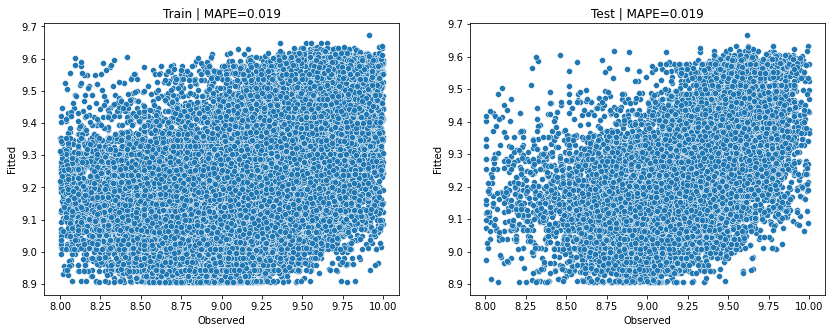

In [56]:
tmp_tr = pd.DataFrame({"true": y_tr.values, "pred": y_fitted_1.values})
tmp_te = pd.DataFrame({"true": y_te.values, "pred": y_pred_1.values})

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

for tmp, ax in zip([tmp_tr, tmp_te], axes.flatten()): 
    sns.scatterplot(data=tmp, x="true", y="pred", ax=ax)
    ax.set_xlabel("Observed")
    ax.set_ylabel("Fitted")

axes[0].set_title(f"Train | MAPE={round(mape_tr_1, 3)}")
axes[1].set_title(f"Test | MAPE={round(mape_te_1, 3)}"); 

La MAPE est calculée sur les valeurs transformées des valeurs foncières. Il semble pertinent de remettre ces valeurs transformées à l"échelle. 

In [71]:
def unscale_target(y: float, area: float) -> float: 
    """Description. Unscale transformed target variable."""

    return area * np.exp(y)

#### Approche `sklearn`

On décide de tester les modèles linéaire implémentés dans la librairie `sklearn` : 
- OLS : `LinearRegression`
- OLS avec pénalisation : `Ridge`, `Lasso`, `ElasticNet` 

In [72]:
results_linear = {}

In [73]:
linear_regressors = [
    LinearRegression(), 
    Ridge(), 
    Lasso(), 
    ElasticNet()
]

for estimator in linear_regressors:
    model_name = estimator.__class__.__name__
    model = CustomRegressor(estimator)

    model.fit(X_tr, y_tr) 
    res_ = {
        "model": model, 
        "mae_tr": model.score(X_tr, y_tr, scoring="mape"), 
        "mae_te": model.score(X_te, y_te, scoring="mape")
    }

    results_linear[model_name] = res_

In [74]:
results_linear

{'LinearRegression': {'model': CustomRegressor(),
  'mae_tr': 0.018950690262262183,
  'mae_te': 0.01908783821003175},
 'Ridge': {'model': CustomRegressor(estimator=Ridge()),
  'mae_tr': 0.018950688579105673,
  'mae_te': 0.019087891377232408},
 'Lasso': {'model': CustomRegressor(estimator=Lasso()),
  'mae_tr': 0.022456230071637173,
  'mae_te': 0.02244256077125438},
 'ElasticNet': {'model': CustomRegressor(estimator=ElasticNet()),
  'mae_tr': 0.022456230071637173,
  'mae_te': 0.02244256077125438}}

In [89]:
# compute mape on unscaled values
mod = results_linear["LinearRegression"]["model"]

y_pred = mod.predict(X_tr)
y_pred_unscaled = unscale_target(y_pred, train_areas)

mean_absolute_percentage_error(y_true=train_prices, y_pred=y_pred_unscaled)

0.24876036043312977

On décide d"optimiser les paramètres des modèles linéaires et de renvoyer la configuration donnant le meilleur score. L"objectif est de minimiser la MAE (Mean Absolute Percentage Error). 

In [63]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [65]:
pipeline = Pipeline([
    ("reg", CustomRegressor())
])

param_grid = [
    {
        "reg__estimator": [LinearRegression()], 
    }, 
    {
        "reg__estimator": [Ridge()], 
        "reg__estimator__alpha": (.01, .1, 1., 10.), 
    }, 
    {
        "reg__estimator": [Lasso()], 
        "reg__estimator__alpha": (.01, .1, 1., 10.), 
    }, 
    {
        "reg__estimator": [ElasticNet()], 
        "reg__estimator__alpha": (.01, .1, 1., 10.), 
        "reg__estimator__l1_ratio": (.1, .3, .5, .8), 
    }
]

g = GridSearchCV(
    estimator=pipeline,    
    param_grid=param_grid, 
    scoring=mape_scorer, 
    n_jobs=CPU_COUNT-1, 
    verbose=2
)
g

GridSearchCV(estimator=Pipeline(steps=[('reg', CustomRegressor())]), n_jobs=7,
             param_grid=[{'reg__estimator': [LinearRegression()]},
                         {'reg__estimator': [Ridge()],
                          'reg__estimator__alpha': (0.01, 0.1, 1.0, 10.0)},
                         {'reg__estimator': [Lasso()],
                          'reg__estimator__alpha': (0.01, 0.1, 1.0, 10.0)},
                         {'reg__estimator': [ElasticNet()],
                          'reg__estimator__alpha': (0.01, 0.1, 1.0, 10.0),
                          'reg__estimator__l1_ratio': (0.1, 0.3, 0.5, 0.8)}],
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=2)

In [66]:
g.fit(X_tr, y_tr)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=Pipeline(steps=[('reg', CustomRegressor())]), n_jobs=7,
             param_grid=[{'reg__estimator': [LinearRegression()]},
                         {'reg__estimator': [Ridge()],
                          'reg__estimator__alpha': (0.01, 0.1, 1.0, 10.0)},
                         {'reg__estimator': [Lasso()],
                          'reg__estimator__alpha': (0.01, 0.1, 1.0, 10.0)},
                         {'reg__estimator': [ElasticNet()],
                          'reg__estimator__alpha': (0.01, 0.1, 1.0, 10.0),
                          'reg__estimator__l1_ratio': (0.1, 0.3, 0.5, 0.8)}],
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=2)

In [67]:
g.best_score_

-0.018970877971832414

In [68]:
best = g.best_estimator_["reg"]
best.get_params()

{'estimator__alpha': 1.0,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': None,
 'estimator__normalize': 'deprecated',
 'estimator__positive': False,
 'estimator__random_state': None,
 'estimator__solver': 'auto',
 'estimator__tol': 0.001,
 'estimator': Ridge()}

In [69]:
from rich.table import Table
from typing import List

def make_coef_table(coefs: np.ndarray, feature_names: List, title: str) -> Table: 
    table = Table(title=title)
    table.add_column("Variable")
    table.add_column("Coef")

    for f, c in zip(feature_names, coefs):
        table.add_row(f, f"{round(c, 3)}")

    return table 

make_coef_table(best.estimator.coef_, feature_names, title="Ridge fine-tuned")

            Ridge fine-tuned            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Variable                    ┃ Coef   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ nombre_pieces_principales_2 │ -0.001 │
│ nombre_pieces_principales_3 │ 0.014  │
│ nombre_pieces_principales_4 │ 0.028  │
│ nombre_pieces_principales_5 │ 0.039  │
│ nombre_pieces_principales_6 │ 0.051  │
│ nombre_pieces_principales_7 │ -0.019 │
│ nombre_pieces_principales_8 │ 0.07   │
│ dependance_1                │ 0.007  │
│ arrondissement_10           │ -0.201 │
│ arrondissement_11           │ -0.173 │
│ arrondissement_12           │ -0.241 │
│ arrondissement_13           │ -0.286 │
│ arrondissement_14           │ -0.197 │
│ arrondissement_15           │ -0.191 │
│ arrondissement_16           │ -0.107 │
│ arrondissement_17           │ -0.152 │
│ arrondissement_18           │ -0.26  │
│ arrondissement_19           │ -0.366 │
│ arrondissement_2            │ -0.081 │
│ arrondissement_20           │ -0.326 │
│ arrondissement_3            │ -0.028 │
│ arrondissement_4            │ 0.029  │
│ arrondissement_5            │ -0.014 │
│ arrondissement_6            │ 0.123  │
│ arrondissement_7            │ 0.095  │
│ arrondissement_8            │ -0.033 │
│ arrondissement_9            │ -0.109 │
│ annee_2018                  │ 0.057  │
│ annee_2019                  │ 0.119  │
│ annee_2020                  │ 0.187  │
│ annee_2021                  │ 0.191  │
│ annee_2022                  │ 0.19   │
│ trimestre_2                 │ 0.009  │
│ trimestre_3                 │ 0.03   │
│ trimestre_4                 │ 0.026  │
└─────────────────────────────┴────────┘

In [70]:
print(f"Train MAPE={round(100*best.score(X_tr, y_tr, scoring="mape"), 2)}%") 
print(f"Test MAPE={round(100*best.score(X_te, y_te, scoring="mape"), 2)}%") 

Train MAPE=1.9%
Test MAPE=1.91%


### Méthodes par partitionnement

#### Arbre de décision - `DecisionTreeRegressor`

Etant donné que l"on dispose d"un grand nombre de variables catégorielles, l"arbre de décision peut être adapté pour prédire le logarithme de la valeur foncière par m². 

In [81]:
tree = CustomRegressor(estimator=DecisionTreeRegressor())
tree.fit(X_tr, y_tr)

for metric in ("r2", "mae", "mape"):
    score_tr = tree.score(X_tr, y_tr, metric)
    score_te = tree.score(X_te, y_te, metric)

    print(f"{metric} on train = {round(score_tr, 3)}")
    print(f"{metric} on test = {round(score_te, 3)}") 

r2 on train = 0.265
r2 on test = 0.203
mae on train = 0.169
mae on test = 0.177
mape on train = 0.018
mape on test = 0.019


On peut optimiser les paramètres du `DecisionTreeRegressor` via `GridSearchCV`. 

In [85]:
pipeline = Pipeline([
    ("reg", CustomRegressor())
])

param_grid = [
    {
        "reg__estimator": [DecisionTreeRegressor()], 
        "reg__estimator__max_depth": (2, 5, 10, 20, 50, 100), 
        "reg__estimator__min_samples_split": (2, 5, 10, 20, 50)
    }
]

g = GridSearchCV(
    estimator=pipeline,    
    param_grid=param_grid, 
    scoring=mape_scorer, 
    n_jobs=CPU_COUNT-1, 
    verbose=2
)
g

GridSearchCV(estimator=Pipeline(steps=[('reg', CustomRegressor())]), n_jobs=7,
             param_grid=[{'reg__estimator': [DecisionTreeRegressor()],
                          'reg__estimator__max_depth': (2, 5, 10, 20, 50, 100),
                          'reg__estimator__min_samples_split': (2, 5, 10, 20,
                                                                50)}],
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=2)

In [86]:
g.fit(X_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(estimator=Pipeline(steps=[('reg', CustomRegressor())]), n_jobs=7,
             param_grid=[{'reg__estimator': [DecisionTreeRegressor(max_depth=20,
                                                                   min_samples_split=50)],
                          'reg__estimator__max_depth': (2, 5, 10, 20, 50, 100),
                          'reg__estimator__min_samples_split': (2, 5, 10, 20,
                                                                50)}],
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=2)

In [87]:
best = g.best_estimator_["reg"]
best.get_params()

{'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': 20,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 50,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeRegressor(max_depth=20, min_samples_split=50)}

In [88]:
for metric in ("r2", "mae", "mape"):
    score_tr = best.score(X_tr, y_tr, metric)
    score_te = best.score(X_te, y_te, metric)

    print(f"{metric} on train = {round(score_tr, 3)}")
    print(f"{metric} on test = {round(score_te, 3)}") 

r2 on train = 0.241
r2 on test = 0.216
mae on train = 0.171
mae on test = 0.175
mape on train = 0.019
mape on test = 0.019


### Méthodes ensemblistes

Pour améliorer la qualité de prédiction, on décide d"utiliser des méthodes ensemblistes qui combinent plusieurs arbres de régression :
- `RandomForestRegressor` pour avoir un modèle à faible variance (apprentissage parallèle)
- `GradientBoostingRegressor` pour avoir un modèle à faible biais (apprentissage séquentiel)
- `XGBRegressor` pour avoir un modèle à faible biais (apprentissage séquentiel)

On commence par entrainer ces 3 modèles sans optimisation des hyper-paramètres. 

In [98]:
results_ensemble = {}

ensemble_models = [
    RandomForestRegressor(), 
    GradientBoostingRegressor(), 
    XGBRegressor()
]

for estimator in ensemble_models:
    model_name = estimator.__class__.__name__
    print(f"Fitting {model_name}...")
    
    model = CustomRegressor(estimator)

    model.fit(X_tr, y_tr) 
    res_ = {
        "model": model, 
        "mae_tr": model.score(X_tr, y_tr, scoring="mape"), 
        "mae_te": model.score(X_te, y_te, scoring="mape")
    }

    results_ensemble[model_name] = res_

Fitting RandomForestRegressor...
Fitting GradientBoostingRegressor...
Fitting XGBRegressor...


In [99]:
results_ensemble

{'RandomForestRegressor': {'model': CustomRegressor(estimator=RandomForestRegressor()),
  'mae_tr': 0.01853615083202878,
  'mae_te': 0.019301827076942734},
 'GradientBoostingRegressor': {'model': CustomRegressor(estimator=GradientBoostingRegressor()),
  'mae_tr': 0.01919610473907428,
  'mae_te': 0.019287430611704796},
 'XGBRegressor': {'model': CustomRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                         callbacks=None, colsample_bylevel=1,
                                         colsample_bynode=1, colsample_bytree=1,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         gamma=0, gpu_id=-1,
                                         grow_policy='depthwise',
                                         importance_type=None,
                

#### Optimisation via `optuna`

In [103]:
def objective_xgb(trial: Trial) -> float:
    """Description. Objective function for XGBRegressor.
    
    Returns: (float) test MAPE."""
   
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
    }

    optuna_model = XGBRegressor(**params)
    optuna_model.fit(X_tr, y_tr)
    y_pred = optuna_model.predict(X_te)

    return mean_absolute_percentage_error(y_te, y_pred)

In [107]:
study_xgb = create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=CPU_COUNT-1)

[I 2023-03-02 20:05:06,186] A new study created in memory with name: no-name-a8450efa-5096-4e21-b94d-5767dc808fcf
C:\Users\pemma\AppData\Local\Temp/ipykernel_2440/1659675273.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
[I 2023-03-02 20:08:36,853] Trial 2 finished with value: 0.019331673618992413 and parameters: {'max_depth': 44, 'learning_rate': 0.43453925886456113, 'n_estimators': 200}. Best is trial 2 with value: 0.019331673618992413.
C:\Users\pemma\AppData\Local\Temp/ipykernel_2440/1659675273.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": tria

In [108]:
study_xgb.best_trial

FrozenTrial(number=17, values=[0.01899261436622099], datetime_start=datetime.datetime(2023, 3, 2, 20, 15, 23, 565482), datetime_complete=datetime.datetime(2023, 3, 2, 20, 15, 48, 134694), params={'max_depth': 5, 'learning_rate': 0.15491320191432018, 'n_estimators': 114}, distributions={'max_depth': IntDistribution(high=50, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=500, log=False, low=50, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=17, state=TrialState.COMPLETE, value=None)

In [110]:
xgb_opt = CustomRegressor(estimator=XGBRegressor(**study_xgb.best_params))
xgb_opt.fit(X_tr, y_tr)

CustomRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.15491320191432018,
                                       max_bin=256, max_cat_threshold=64,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=5, max_leaves=0,
                    

In [111]:
for metric in ("r2", "mae", "mape"):
    score_tr = xgb_opt.score(X_tr, y_tr, metric)
    score_te = xgb_opt.score(X_te, y_te, metric)

    print(f"{metric} on train = {round(score_tr, 3)}")
    print(f"{metric} on test = {round(score_te, 3)}") 

r2 on train = 0.236
r2 on test = 0.227
mae on train = 0.171
mae on test = 0.173
mape on train = 0.019
mape on test = 0.019
